# Hands-On ML: Chapter 8, Dimensionality Reduction

We mentioned many times the problem of large datasets. Firstly, many models do not scale well with greater feature size and/or instances. Second, it is harder to model relationships when data sizes increase (think knn when dimension grows). This is called the `curse of dimensionality`. Therefore, it is crucial for us to learn about methods to reduce the number of features. In addition, we need to balance information loss and dimensionality reduction to get the best performance in our models. We will go through the two main approaches `projection` and `Manifold Learning` and the three most popular techniques of `PCA`, `Kernel PCA` and `LLE`.

Summary

1. Curse of Dimensionality
2. Projection 
3. Manifold Learning 
4. Principal Component Analysis (PCA)
5. Tuning PCA parameters & different PCA implementations
6. Locally Linear Embedding
7. Other techniques


### Curse of Dimensionality

Curse of dimensionality is best explained with examples. If you pick two points randomly in a unit square, the distance between them on average is **~0.52**. In a 3D cube, it will be **~0.66**. In a 1,000,000-dimensional hypercube it will be **~408.25**--- on average points are further apart in high-dimensional hypercubes (read elements of statistical learning for a more mathematical example). The **critical issue** is that statistical models predict new inputs based on old inputs (training). If the new data is far away from training data points the model was exposed it, it will require larger extrapolations. Hence, at higher dimensions, models tend to be overfitted and struggle to generalize.

----------

### Main Approaches (Also please go back to your linear algebra notes)

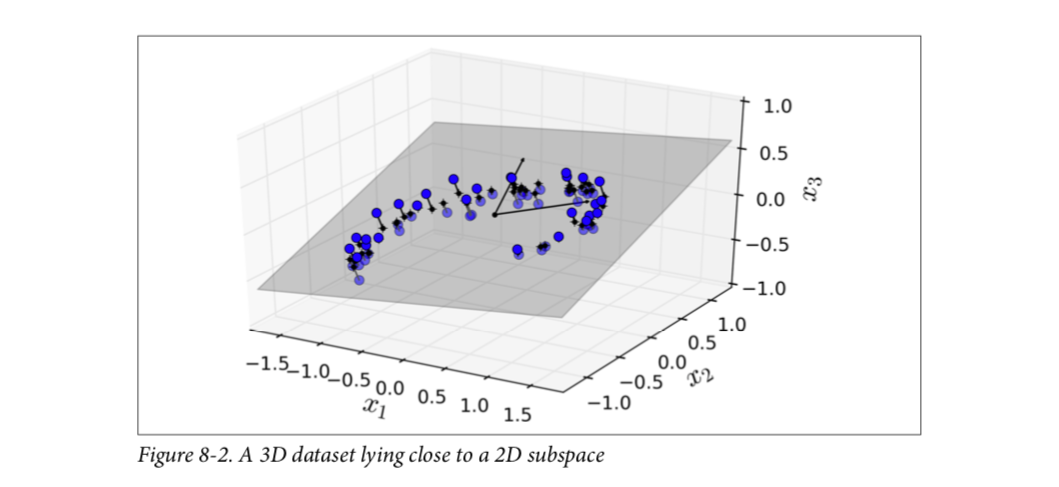

In [1]:
from IPython.display import Image
Image(filename = './images/projection.png')

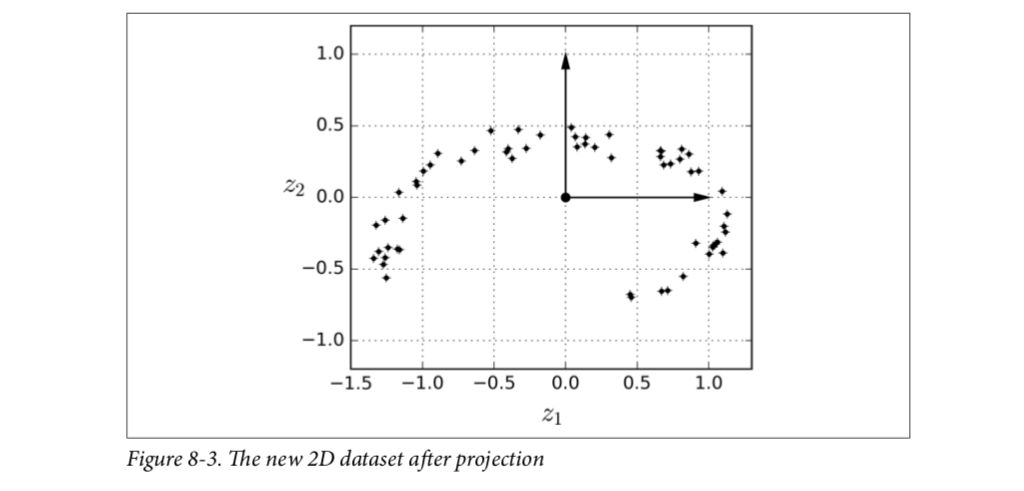

In [6]:
Image(filename = './images/projected_2d_subspace.png')

### 1. **Projection**: 

We can solve for a plane that all data points are perpendicular to, and project the points onto that plane. As you can above, it can work very well, we preserve the semi-curve shape of the data which is informative and possibly predictable. However, there are also cases like Swiss-roll which is difficult to project onto a 2D plane without losing crucial information. The correct procedure for the Swiss-roll is to unroll it, not squash and project it.

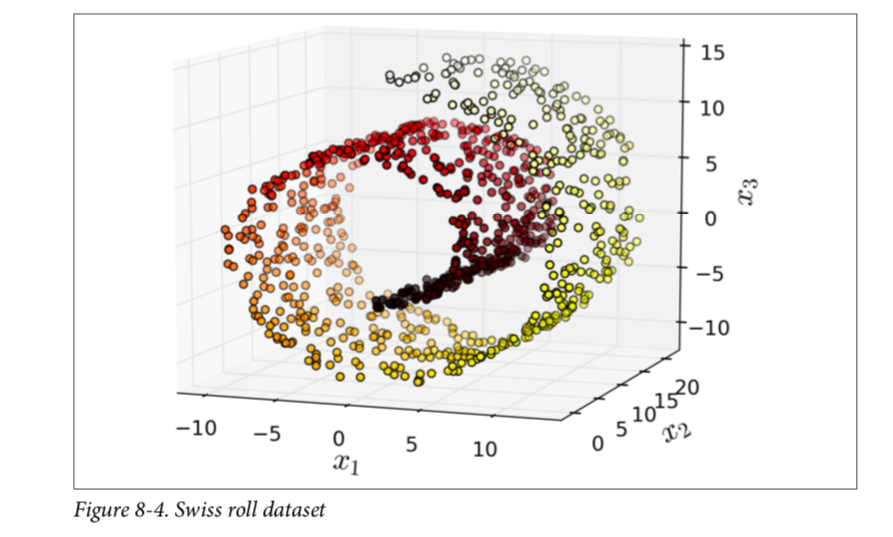

In [7]:
Image(filename = './images/swiss_roll.png')

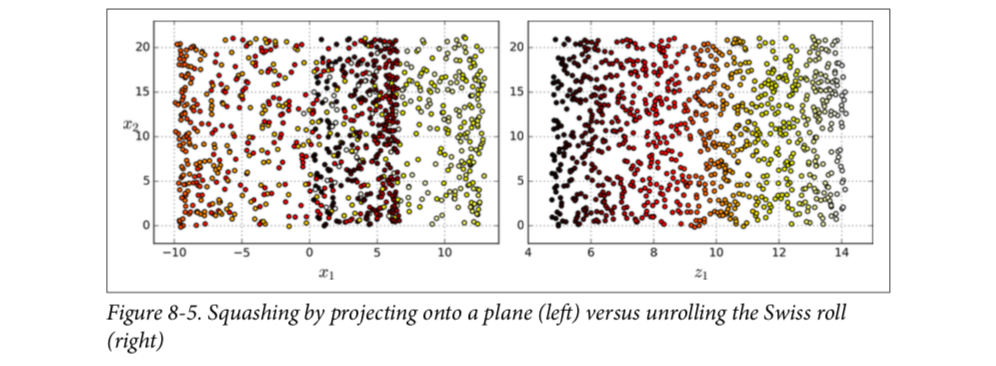

In [8]:
Image(filename = './images/swiss_roll_projection.png')

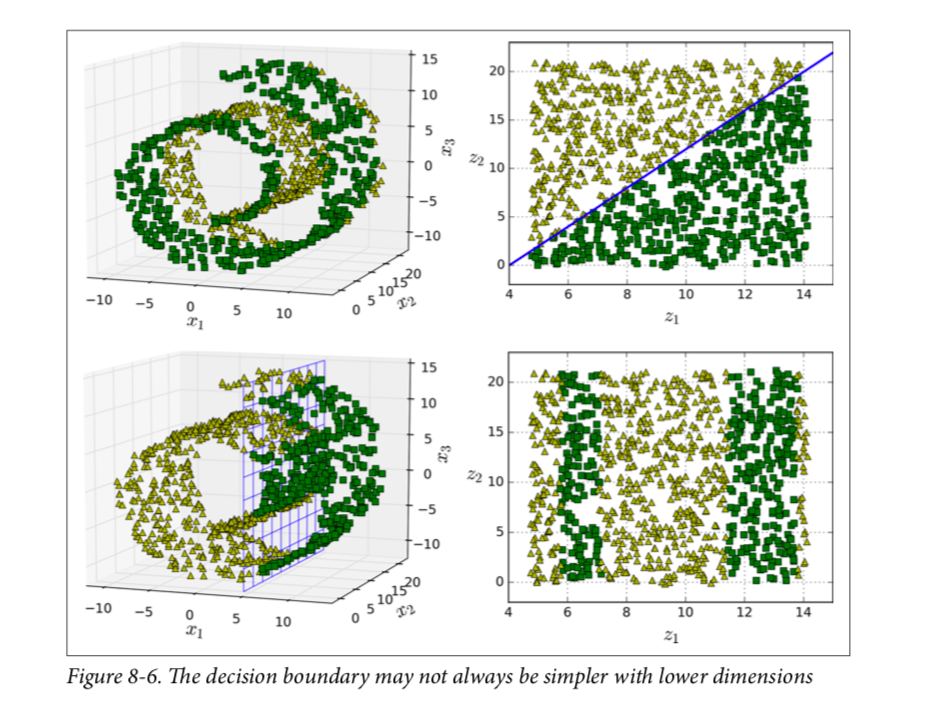

In [9]:
Image(filename = './images/manifold_shortcomings.png')

### 2. Manifold Learning: 

The Swiss-roll is an example of a 2D manifold. A 2D manifold is a 2D shape that can be bent and twisted in a higher-dimensional space. More generally, a d-dimensional manifold is apart of an n-dimensional space (where d < n) that locally resembles a d-dimensional hyperplane. In the case of the Swiss-roll, d = 2 and n = 3. 

Many dimensionality reducition algorithms model the manifold itself, this is called `Manifold Learning`. It relies on the `manifold assumption` / ` Manifold Hypothesis`-- which holds that most real-world high-dimensional datasets lie close to a much lower-dimensional manifold. Surprisingly, this assumption is *very* often empirically observed.

An implicit assumption of `Manifold Learning` is that the classification/regression task will be simplier if expressed in lower-dimensional space of the manifold. This is not always true. The example above shows that simply looking down x3 axis will give a clear separating hyper-plane that performs perfectly. But unrolling the manifold will result in a more complicated learning problem, with 4 divides.

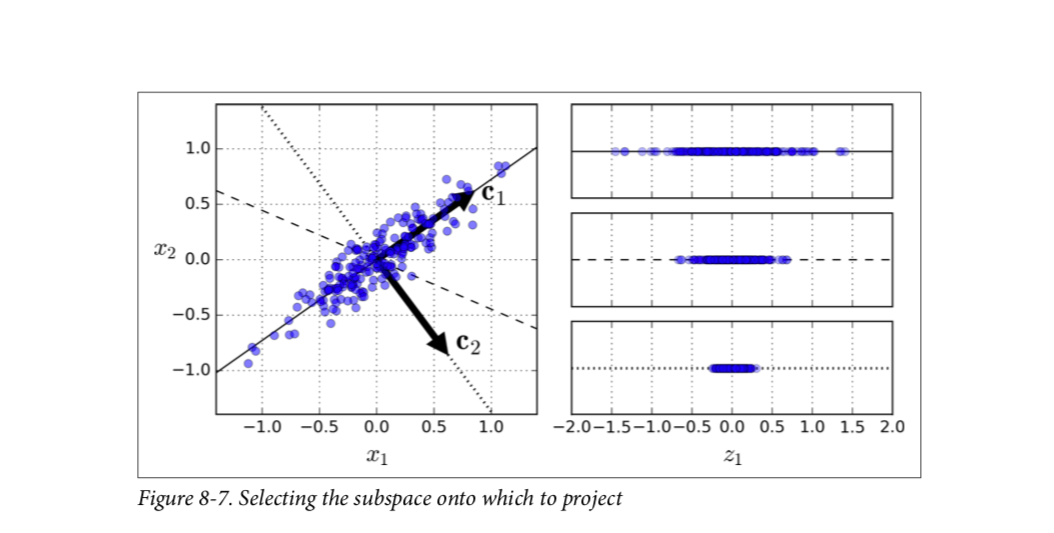

In [11]:
Image(filename = './images/pca.png')

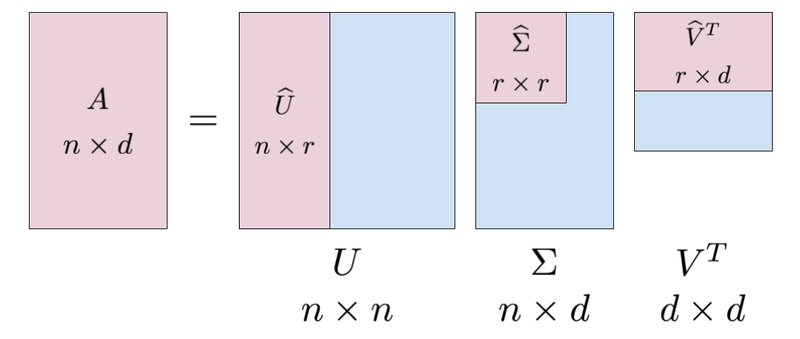

In [14]:
Image(filename = './images/svd_matrices.png')

### 3. Principal Component Analysis (PCA)

PCA is by far the **most popular** algorithm for dimensionality reduction. First it identifies the hyperplane that lies closest to the data, and then it projects the data onto it. Imagine doing projection like before, but having a way to decide which projection is the best.

**How do we define best?** In the figure above, the 2D dataset is projected onto three 1D hyperplanes/lines. The line that preserves the most information at lower dimension is the one that has the highest variance. Hence, we can intepret the problem as finding a lower dimensional hyperplane with the highest variance. In practice, this also means minimizing the mean squared distance between the origianl dataset and its projection onto that axis.

**Principal Components:** PCA algorithm sequentially idenitfies the axis that account for the largest amount of variance in the training set. These are called principal components. In figure 8-7, PC1 is the solid line, PC2 is the dash line and PC3 is the dotted line. The direction of the principal components is not stable; a slight perturb of the training set can result in PCs pointing in the opposite direction. However, they will generally lie on the same axis and define the same hyperplane.

**SVD to find PCs:** The principal components can be determine with Singular Value Decomposition (SVD)-- **please read your linear algebra notes**. SVD is a standard matrix factorization technique that decomposes a matrix X into the dot product of three matrices U, sigma and Vt. Vt will contain the principal components.


In [18]:
#Create dataset
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [24]:
#Use numpy SVD function
X_centered = X - X.mean(axis = 0) #PCA assumes the dataset is centered around the origin
U, s, V = np.linalg.svd(X_centered)
c1 = V.T[:, 0]
c2 = V.T[:, 1]
print(c1)
print(c2)

[0.93636116 0.29854881 0.18465208]
[-0.34027485  0.90119108  0.2684542 ]


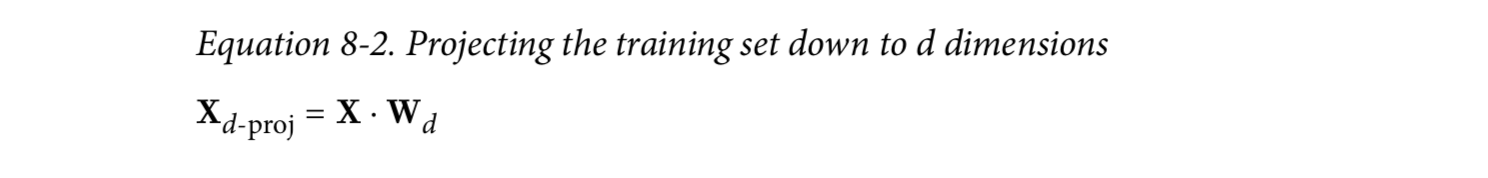

In [25]:
Image(filename = './images/pca_projection.png')

After performing SVD, we get n principal components. We can then reduce dimensionality by projecting the data onto a hyperplane defined by the first d principal components we choose. As explained briefly above, this process ensures we select a hyperplane the perserves as much variance as possible for the dimension we choose. Projection is simply the dot product between the dataset X and a matrix of the first d principal components.

In [28]:
W2 = V.T[:, :2]
X2D = X_centered.dot(W2)

In [38]:
#Sklearn PCA will automatically center the matrix
from sklearn.decomposition import PCA
pca = PCA(n_components = 2) #let's project to 2 dimensions
X2D = pca.fit_transform(X)

In [39]:
#You can access the components as well
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

### Explained Variance Ratio

The `explained variance ratio` can be quite useful in deciding how many dimensions we should project to. It indicates the proportion of variance that lies along the axis of each principal component. We can see below that 77.8% of the variance is explained by the first component and 13.5% explained by the second. That leaves 8.7% of the variance to be explained-- we probably won't benefit much from adding another dimension.

In [40]:
pca.explained_variance_

array([0.77830975, 0.1351726 ])

### Choosing the Right Dimensions

Generally, we choose to reduce dimensionality until we explain a sufficient portion of the variance e.g. 95%. There are several options to code this:

In [42]:
#Option 1: Specify the threshold (e.g. 95%) and choose the d number of PCs that sum up to that
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1 #Plus 1 because index starts at 0
d

2

In [51]:
#Option 2: Specify ratio you want to target between 0 and 1. PCA will automatcially
#identify that between 0-1, you are specifying the variance explained
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X)

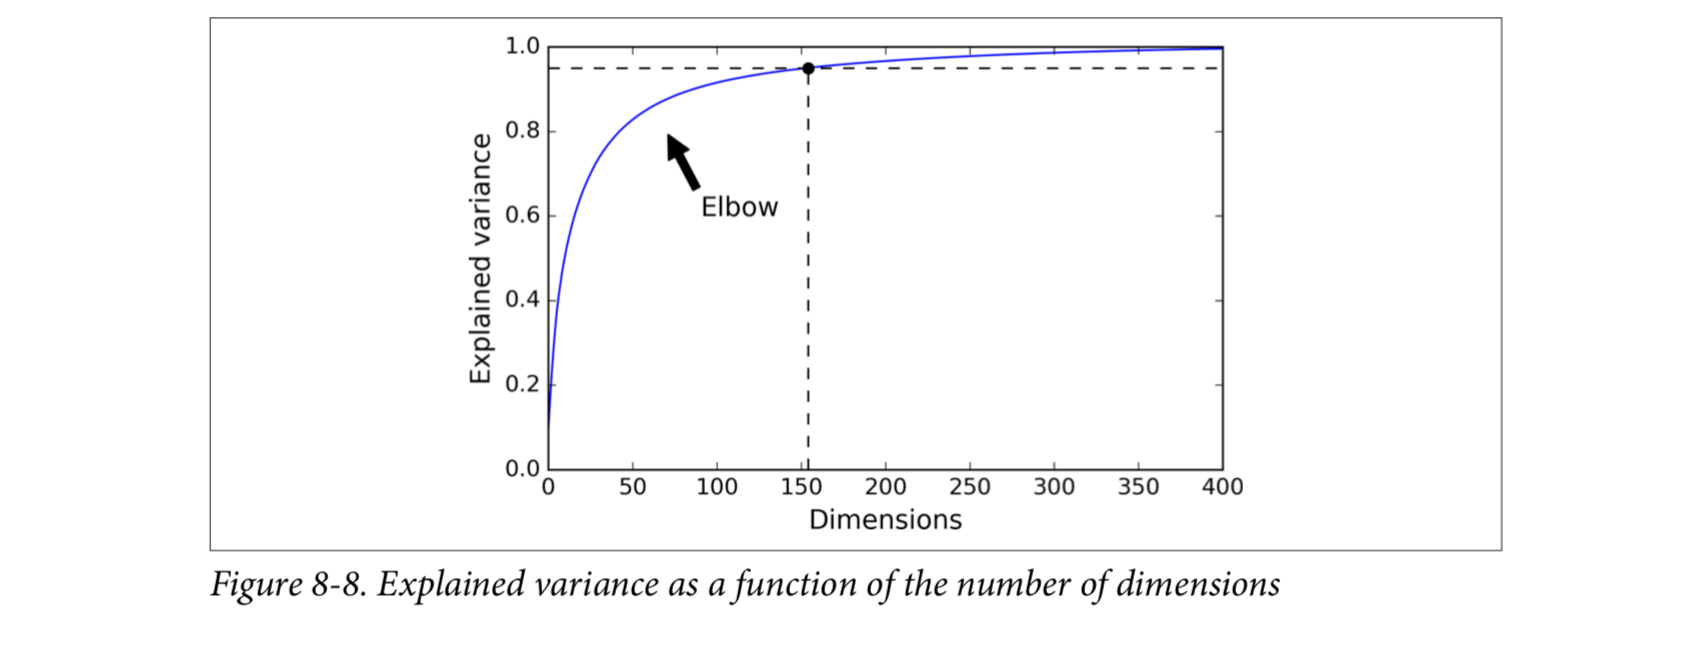

In [53]:
#Option 3: Plot out the variance versus dimensions and search for either the 
#target variance explained or the plateau
Image(filename = './images/explained_variance_plot.png')

### PCA For Compression

Dimensionality reduction is a form of compression. If we take the MNIST data, PCA can compress it from 784 features to just 150 features while preserving 95% variance. In addition, we can **decompress** by performing the inverse transformation of the PCA projection. Of course, some information is loss. In fact, we can compute the `reconstruction error`-- which is the mean-squred distance between the new data and the original data. 

In [13]:
#MNIST Data
from sklearn.datasets import fetch_openml
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [14]:
pca = PCA(n_components = 154)
X_mnist_reduced = pca.fit_transform(X)
X_mnist_recovered = pca.inverse_transform(X_mnist_reduced) #inverse of PCA projection

### Incremental PCA

As we noticed with performing PCA on the MNIST dataset, it scales poorly with large datasets. That is because PCA has fit the entire training data in memory to run the SVD algorithm. Fortunately, there are `Incremental PCA` algorithms that allow us to apply PCA on mini-batches. This can also be used to apply PCA on the fly, e.g. as new data arrives 

In [15]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100 #let's split the data into 100 batches
inc_pca = IncrementalPCA(n_components = 154) #still 154 principal components

for X_batch in np.array_split(X, n_batches): #split matrix in 100 batches and feed into for loop
    inc_pca.partial_fit(X_batch) #partial fit, instead of fit_transform
    
X_mnist_reduced = inc_pca.transform(X) #Now do the transform

In [ ]:
#numpy mmep alternative
#mmemap is like a generator write/read function
#It will split a stored file and read only the data necessary
X_mm = np.memmap(filename, dtype = 'float32', mode = 'readonly', shape = (m, n))

### Randomized PCA

Another option is `Randomized PCA`. This is a stochastic algorithm that quickly finds an approximation of the first d principal components. Its computational complexity is O(m x d^2) + O(d^3) instead of O(m x n^2) + O(n^3). Hence, it is dramatically faster than the previous algorithims when **d is much smaller than n**. 

In [64]:
rnd_pca = PCA(n_components = 154, svd_solver = 'randomized')
X_reduced = rnd_pca.fit_transform(X)

### Kernel PCA

Recall the kernel trick in Chapter 5-- we can use the dot product to implicitly map instances into a very high-dimensional space (called feature space), enabling nonlinear classification and regression with SVM. Recall that a linear decision boundary in the high-dimensional **feature space** corresponds to a complex nonlinear decision boundary in the **original space**.

It turns out the same trick applies to PCA, making it possible to perform complex nonlinear projections for dimensionality reduction. This is called `Kernel PCA (kPCA)`. It is often good at preserving clusters of instances after projection, or sometimes even unrolling datasets that lie close to a twisted manifold.

In [ ]:
#We can use rbf kernel 
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel = 'rbf', gamma = 0.04)
X_reduced = rbf_pca.fit_transform(X)

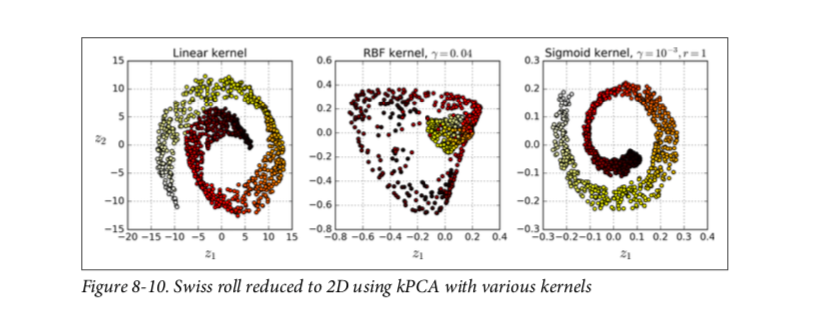

In [21]:
#The swiss roll reduced from 3D to 2D using different kernels
Image(filename = './images/kernel_pca.png')

### Selecting a Kernel and Tuning Hyperparameters (Slower)

By itself, PCA is an unsupervised task with no obvious performance measure. But it is also typically a step performed before the supervised learning task. Hence, we can simply write a grid search pipeline that does this:

1. Define pipeline that performs kPCA and fits a model
2. Define parameter grid with kernel parameters
3. Use GridSearchCV() to find the best parameters



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ('kpca', KernelPCA(n_components = 2)),
    ('log_reg', LogisticRegression())
])

#Grid with parameter names + settings to try
#We are only specifying parameters for KernelPCA right now
param_grid = [{
    'kernel__gamma' : np.linesapce(0.03, 0.05, 10),
    'kpca__kernel' : ['rbf', 'sigmoid']
}]

grid_search = GridSearchCV(clf, param_grid, cv = 3)
grid_search.fit(X, y)

print(grid_search.best_params_)

A fully non-supervised approach would be to select the kernel and parameters that has the lowest `reconstruction error`. However, this is much more difficult with the kernel trick (and nonlinearity). Look at the diagram below:

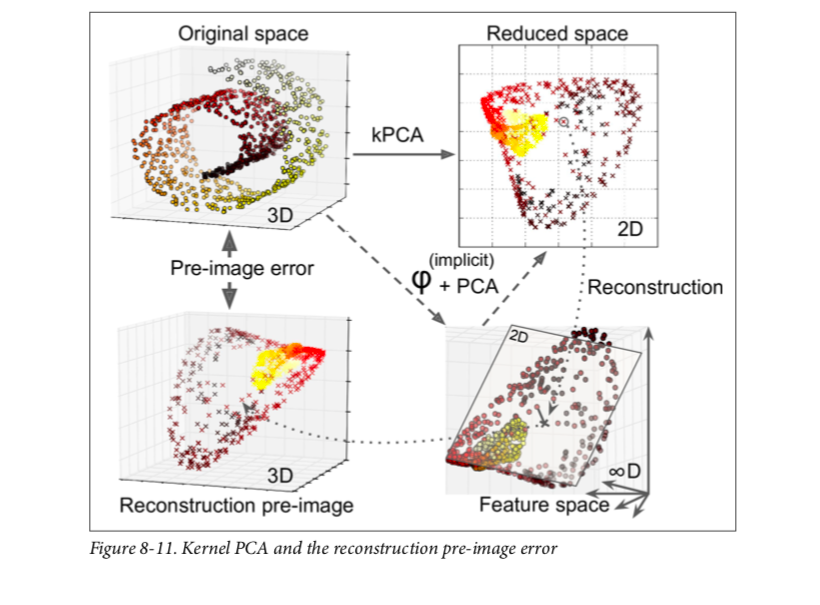

In [26]:
Image(filename = './images/kernel_trick_reconstruction.png')

What is happening above?

1. kPCA with RBF kernel projects the swiss roll to a reduced space (top-right)
2. With the kernel trick, this is equivalent to mapping the data to an **infinite-dimensional** feature space, then projecting that data to a 2D plane using PCA (top-right). 
3. When we do inverse PCA, the reconstruction would be in a infinite-dimensional feature space. We cannot compute the reconstruction error with this, but we also cannot perform the exact inverse of the kernel trick. (bottom-right)
4. What we can do is simply map the reconstruction (bottom-right) to the nearest point in the initial dimensions. This is called **reconstruction pre-image** (bottom-left).

One way to create the reconstruction pre-image is to train a supervised regression model with the projected instances as features and the original instances as response values.

In [ ]:
#Training a reconstruction model
rbf_pca = KernelPCA(n_components = 2, kernel = 'rbf', gamma = 0.0433,
                   fit_inverse_transform = True) #setting fit_inverse_transform will fit the regression in the background

X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [ ]:
#Compute the error
#We can use grid-search to minimize the error
from sklearn.metrics import mean_squared_error
mean_squared_error(X, X_preimage)

### Locally Linear Embedding (LLE)

LLE is another very powerful nonlinear dimensionality reduction (NLDR) technique. It is a Manifold Learning technique that **does not reply on** projections like the previous algorithms. In a nutshell, LLE works like:

1. Measures how each training instance linearly relates to its closest neighbors
2. Look for a low-dimensional representation of the training set where these local relationships are best preserved

**Details:**

1. Like lowess, LLE begins by looking at the k closest neighbours for each x. It then fits a linear function on these x's to estimate the particular x. This is simply done by minimizing least squares.

2. 

### Other dimensionality reduction techniques

1. Multidimensional Scaling (MDS) reduces dimensionality while trying to preserve the distances between the instances.
2. Isomap creates a graphy by connecting each instance to its nearest neighbours, then reduces dimensionality while trying to preserve the geodesic distances between the instances.
3. t-Distributed Stochastic Neighbor Embedding (t-SNE) reduces dimensionality while trying to keep similar instances close and dissimilar instances apart. It is mostly used for visualization, in particular to visualize clusters of instances in high-dimensional space (e.g. to visualize the MNIST images in 2D).
4. Linear Discriminat Analysis (LDA) can be applied outside of classification. During training, it learns the most discriminative axes between the classes, and these axes can then be used to define a hyperplane onto which to project the data. The benefit is that it'll select projections that keep the classes as far apart as possible.